# 🤖📈 LangChain Stock Agent with Yahoo Finance + Memory

This notebook uses **Yahoo Finance (via `yfinance`)** to fetch real-time stock prices and historical data, wrapped as tools usable by a **LangChain agent with memory**.


In [ ]:
# !pip install yfinance matplotlib pandas langchain langchain-openai langchain-core

In [1]:
pip install yfinance matplotlib pandas langchain langchain-openai langchain-core

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import yfinance as yf
import os
import pandas as pd
import matplotlib.pyplot as plt
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import display, Markdown
import re


In [12]:
def get_price(symbol: str) -> str:
    ticker = yf.Ticker(symbol)
    info = ticker.info
    price = info.get("regularMarketPrice", "N/A")
    currency = info.get("currency", "")
    return f"The current price of {symbol.upper()} is {price} {currency}."

def get_series(symbol: str, days: int = 30):
    df = yf.download(symbol, period="1mo", interval="1d")
    if df.empty:
        return f"No data found for {symbol}"
    df['Close'].plot(title=f"{symbol.upper()} – Last 30 Days")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.show()
    return f"Displayed the last 30-day trend for {symbol.upper()}."


def get_last_symbol_from_memory(mem):
    """Extracts the last mentioned stock ticker symbol (AAPL, TSLA, etc.) from memory."""
    pattern = re.compile(r"\b[A-Z]{1,5}\b")  # stock-like tokens
    for msg in reversed(mem.chat_memory.messages):
        if isinstance(msg.content, str):
            matches = pattern.findall(msg.content.upper())
            for m in matches:
                # Exclude generic uppercase words
                if m not in {"SHOW", "THE", "WITH", "FROM", "PRICE", "TREND", "OF", "STOCK", "ITS", "RECENT"}:
                    return m
    return None


def series_tool_with_memory(symbol: str = None):
    """Tool that uses memory if no symbol is passed directly."""
    if symbol is not None:
        symbol = symbol.strip().split()[0].upper()  # ✅ clean hallucinated inputs
    if not symbol or symbol == "NONE":
        symbol = get_last_symbol_from_memory(memory)
    if not symbol:
        return "❌ No valid stock symbol found in memory. Please specify explicitly like 'trend of AAPL'."
    return get_series(symbol)



In [14]:
tools = [
Tool(name="price_tool", func=get_price, description="Fetch the real-time stock price of a ticker using Yahoo Finance."),
    Tool(name="series_tool", func=series_tool_with_memory, description="Use this tool to show a 30-day trend of a stock using its symbol. Accepts symbols like 'AAPL', 'TSLA', or 'MSFT'.")
]

In [7]:
!pip install -U langchain-openai

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
model_key = "Enter_your_API_KEY"

In [ ]:
model_api="https://llama-3-1-8b-instruct-maas-apicast-production.apps.prod.rhoai.rh-aiservices-bu.com:443/v1"
model="meta-llama/Llama-3.1-8B-Instruct"

llm = ChatOpenAI(
    model=model,
    base_url=model_api,
    api_key=model_key,
    temperature=0.3,
)
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

agent_with_memory = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    memory=memory,
    verbose=True,
    max_iterations=20  # 👈 raise it from default 5
)

In [9]:
# def run_agent(query):
#     response = agent_with_memory.invoke({"input": query})
#     display(Markdown("### 📊 Agent's Response"))
#     display(Markdown(response["output"]))

#     chat = response.get("chat_history", [])
#     structured = [{"role": "user" if isinstance(m, HumanMessage) else "agent", "content": m.content} for m in chat]
#     display(Markdown("### 🧠 Memory Snapshot"))
#     for msg in structured:
#         who = "👤 You" if msg["role"] == "user" else "🤖 Agent"
#         display(Markdown(f"**{who}:** {msg['content']}"))

#     return response
def run_agent(query):
    response = agent_with_memory.invoke({"input": query})
    display(Markdown("### 📊 Agent's Response"))
    display(Markdown(response["output"]))

    chat = response.get("chat_history", [])
    structured = [{"role": "user" if isinstance(m, HumanMessage) else "agent", "content": m.content} for m in chat]
    display(Markdown("### 🧠 Memory Snapshot"))
    for msg in structured:
        who = "👤 You" if msg["role"] == "user" else "🤖 Agent"
        display(Markdown(f"**{who}:** {msg['content']}"))

    # remove this → return response


## 🧪 Try a Live Query

In [10]:
_=run_agent("What's the current price of IBM?")



> Entering new AgentExecutor chain...
Thought: To find the current price of IBM, I need to use a tool that can fetch real-time stock prices.
Action: price_tool
Action Input: IBM
Observation: The current price of IBM is 283.21 USD.
Thought:Question: What's the current price of IBM?
Thought: Thought: To find the current price of IBM, I need to use a tool that can fetch real-time stock prices.
Action: price_tool
Action Input: IBM
Observation: The current price of IBM is 283.21 USD.
Thought:Question: What's the current price of IBM?
Thought: To find the current price of IBM, I need to use a tool that can fetch real-time stock prices.
Action: price_tool
Action Input: IBM
Observation: The current price of IBM is 283.21 USD.
Thought:Question: What's the current price of IBM?
Thought: To find the current price of IBM, I need to use a tool that can fetch real-time stock prices.
Action: price_tool
Action Input: IBM
Observation: The current price of IBM is 283.21 USD.
Thought:Question: What's t

### 📊 Agent's Response

The current price of IBM is 283.21 USD.

### 🧠 Memory Snapshot

**👤 You:** What's the current price of IBM?

**🤖 Agent:** The current price of IBM is 283.21 USD.



> Entering new AgentExecutor chain...
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.

Action: series_tool
Action Input: None (I will ask for the symbol later)
Observation: ❌ No valid stock symbol found in memory. Please specify explicitly like 'trend of AAPL'.
Thought:Question: Show me its recent trend
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.
Action: series_tool
Action Input: None (I will ask for the symbol later)
Observation: ❌ No valid stock symbol found in memory. Please specify explicitly like 'trend of AAPL'.
Thought:Question: Show me its recent trend
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.
Action: series_tool
Action Input: None (I will ask for the symbol later)
Observation: ❌ No valid stock symbol found in memory. Please specify explicitly like 'trend of AAPL'.


/tmp/ipykernel_566868/2666558166.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


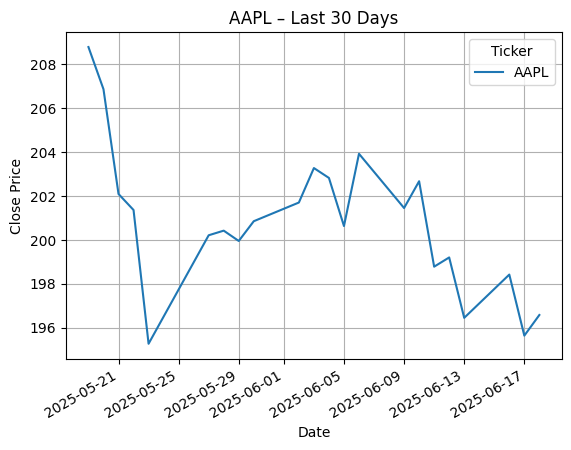


Observation: Displayed the last 30-day trend for AAPL.
Thought:Question: Show me its recent trend
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.
Action: series_tool
Action Input: AAPL

/tmp/ipykernel_566868/2666558166.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


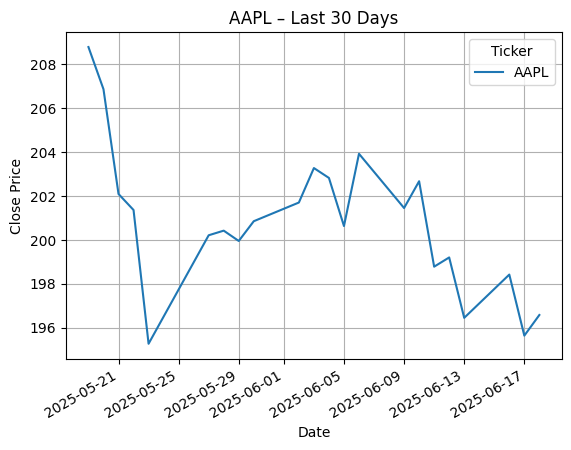


Observation: Displayed the last 30-day trend for AAPL.
Thought:Question: Show me its recent trend
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.
Action: series_tool
Action Input: AAPL

/tmp/ipykernel_566868/2666558166.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


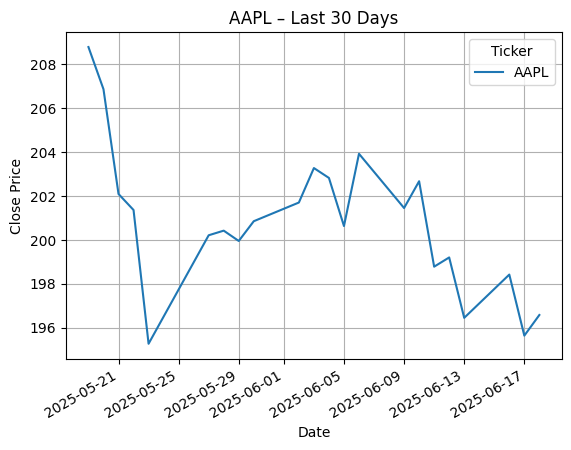


Observation: Displayed the last 30-day trend for AAPL.
Thought:Question: Show me its recent trend
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.
Action: series_tool
Action Input: AAPL

/tmp/ipykernel_566868/2666558166.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


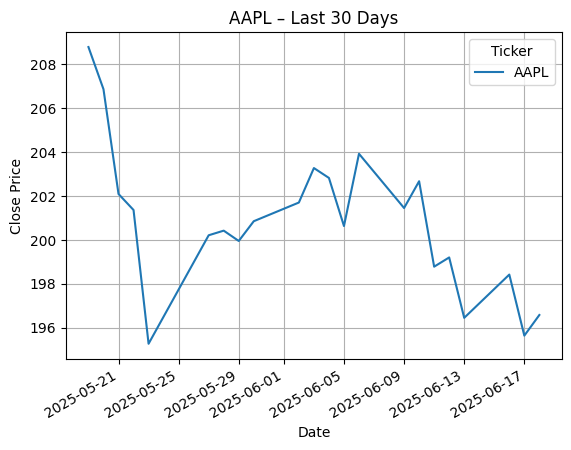


Observation: Displayed the last 30-day trend for AAPL.
Thought:Question: Show me its recent trend
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.
Action: series_tool
Action Input: AAPL

/tmp/ipykernel_566868/2666558166.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


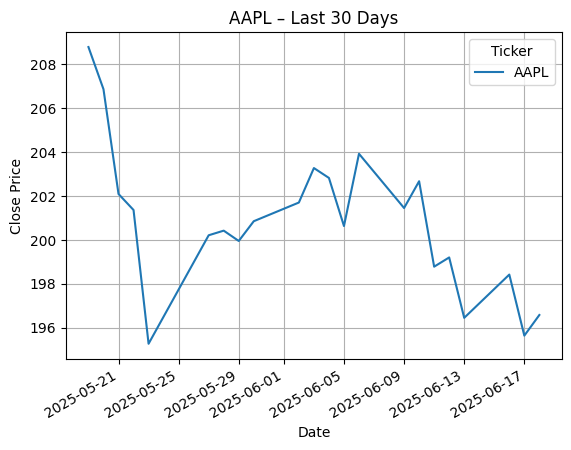


Observation: Displayed the last 30-day trend for AAPL.
Thought:Question: Show me its recent trend
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.
Action: series_tool
Action Input: AAPL

/tmp/ipykernel_566868/2666558166.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


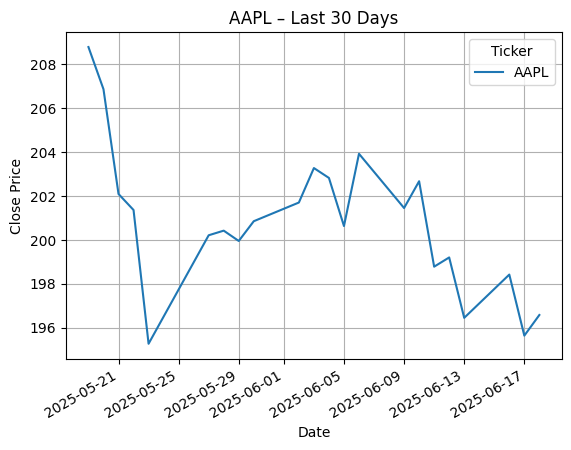


Observation: Displayed the last 30-day trend for AAPL.
Thought:Question: Show me its recent trend
Thought: To show the recent trend of a stock, I need to use the series_tool to display a 30-day trend of the stock.
Action: series_tool
Action Input: AAPL

/tmp/ipykernel_566868/2666558166.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


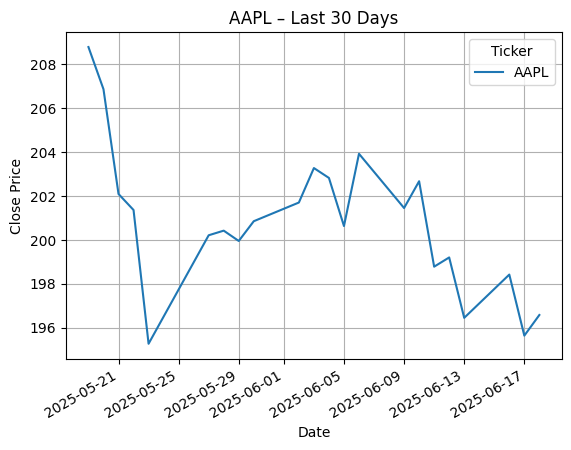


Observation: Displayed the last 30-day trend for AAPL.
Thought:Thought: I now know the final answer
Final Answer: The last 30-day trend for AAPL.

> Finished chain.


### 📊 Agent's Response

The last 30-day trend for AAPL.

### 🧠 Memory Snapshot

**👤 You:** Show me its recent trend

**🤖 Agent:** The last 30-day trend for AAPL.

In [16]:
_=run_agent("Show me its recent trend")

### 💬 Interactive Chat

In [ ]:
while True:
    q = input("You: ")
    if q.lower() in {"quit", "exit"}:
        break
    run_agent(q)